In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluation


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import boxcox

Import del dataset da file csv come dataframe usando pandas

In [3]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)


Cambio di scala area e codifica dei mesi e dei giorni

In [4]:
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)
# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'], inplace=True)
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152,-0.866025
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025


2) I vari modelli nella versione 1 non riescono a fare previsione corrette. Una possibilità è quella di lavorare sugli outliers

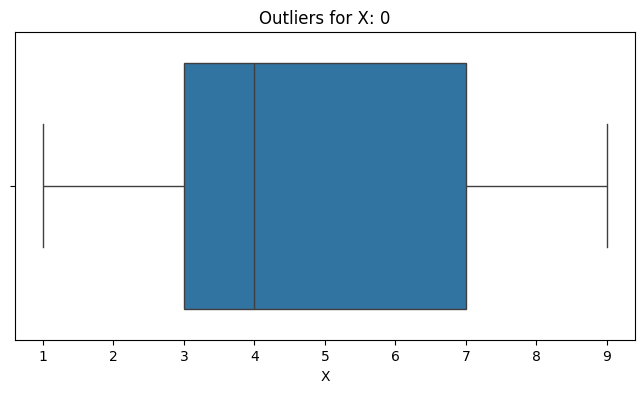

Colonna X: 0 outliers


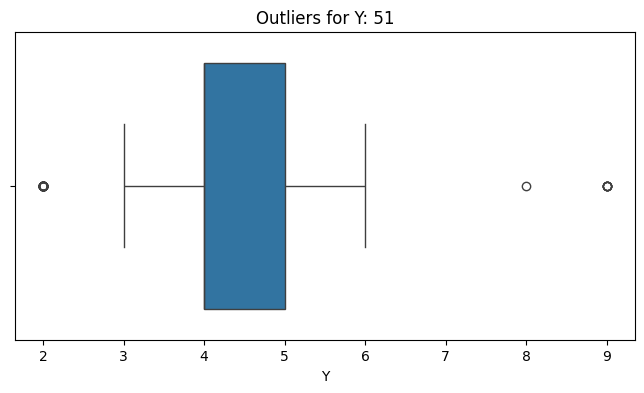

Colonna Y: 51 outliers


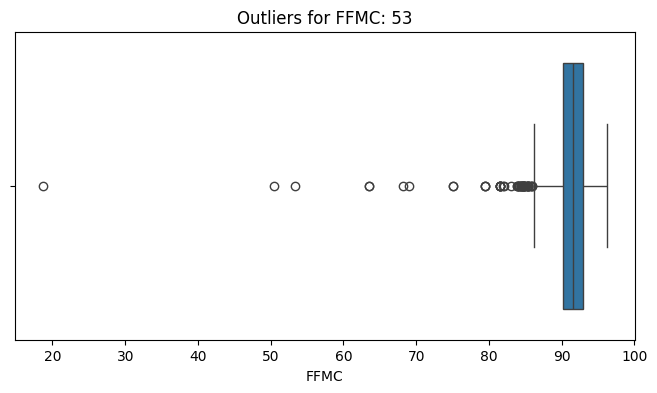

Colonna FFMC: 53 outliers


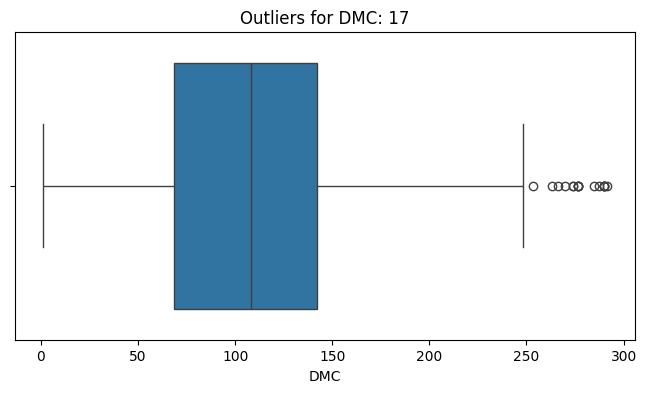

Colonna DMC: 17 outliers


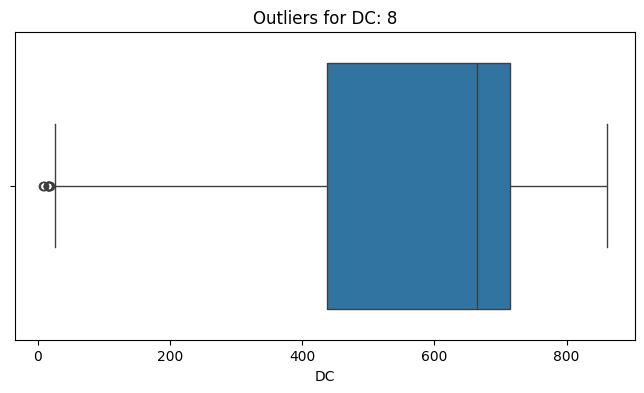

Colonna DC: 8 outliers


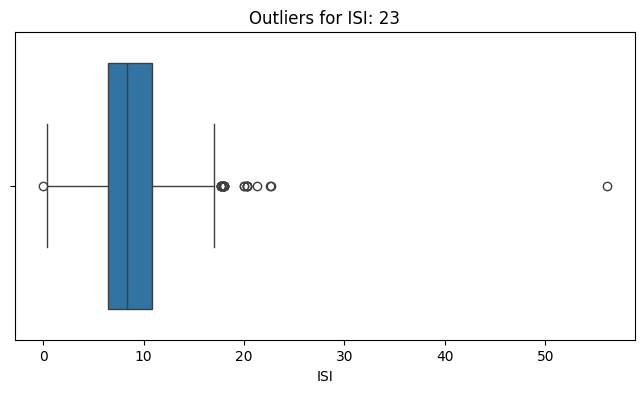

Colonna ISI: 23 outliers


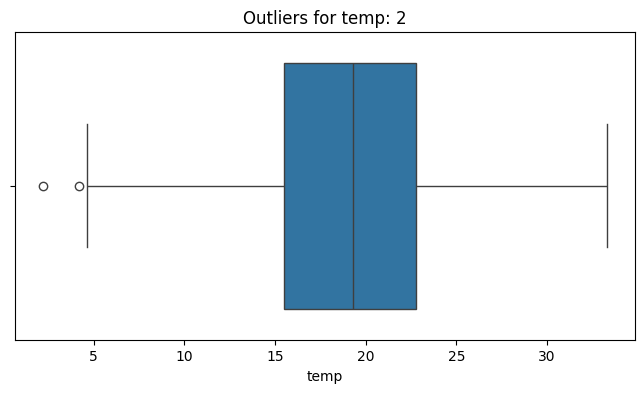

Colonna temp: 2 outliers


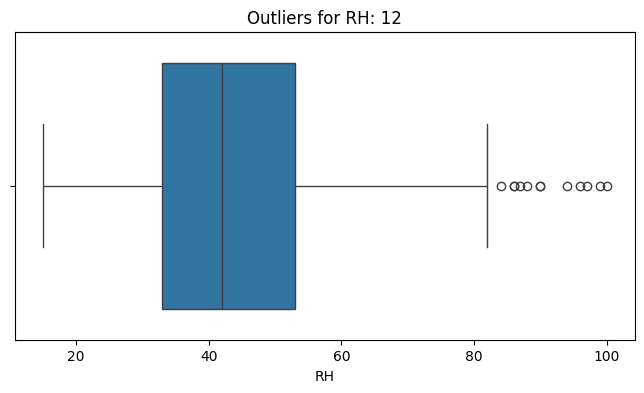

Colonna RH: 12 outliers


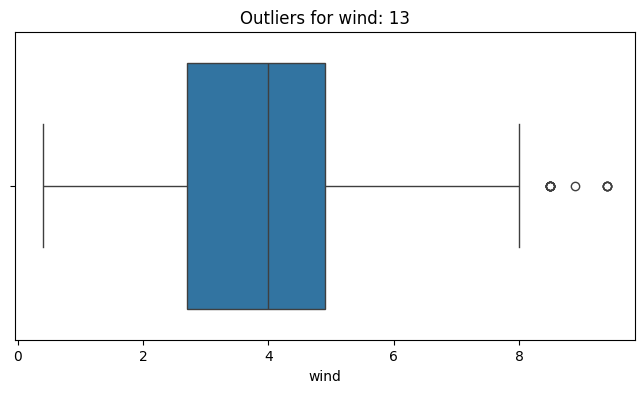

Colonna wind: 13 outliers


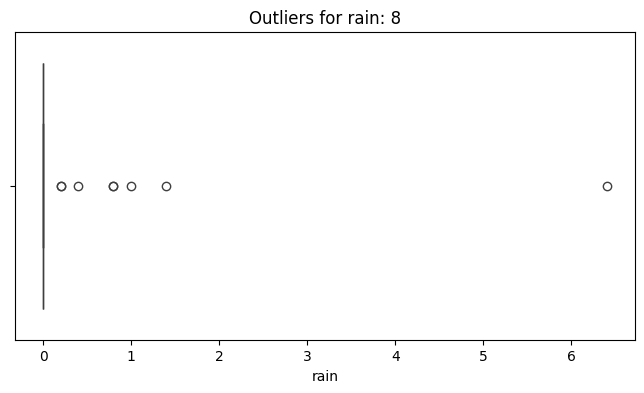

Colonna rain: 8 outliers


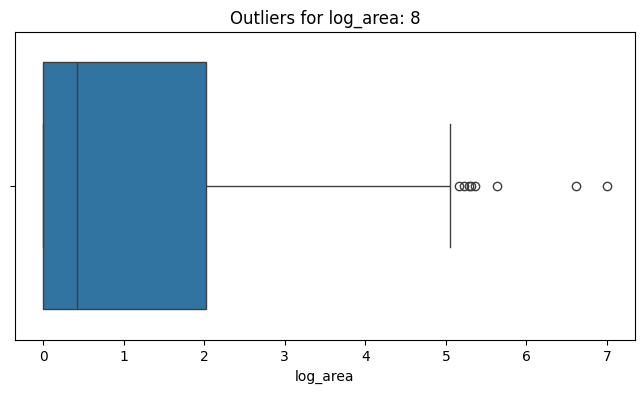

Colonna log_area: 8 outliers


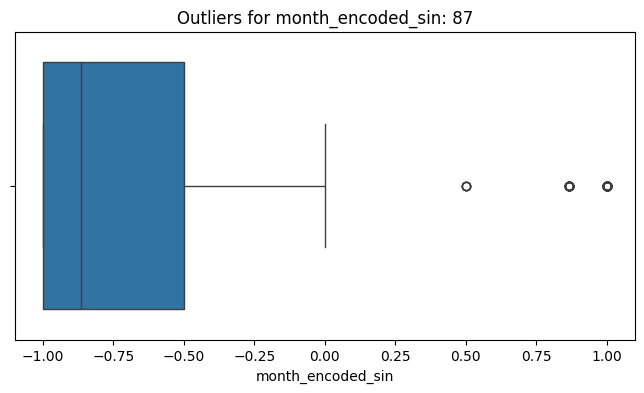

Colonna month_encoded_sin: 87 outliers


In [5]:
df_temp = df
for col in df_temp.select_dtypes(include=['float', 'int']).columns:
    
    # Calcola i quartili Q1 e Q3 e l'IQR
    Q1 = df_temp[col].quantile(0.25)
    Q3 = df_temp[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definisci i limiti per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtra gli outlier
    outliers = df_temp[(df_temp[col] < lower_bound) | (df_temp[col] > upper_bound)]
    
    # Conta il numero di outlier
    num_outliers = outliers.shape[0]
    
    # Visualizza il boxplot per la variabile
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_temp, x=col)
    plt.title(f'Outliers for {col}: {num_outliers}')
    plt.show()
    
    # Stampa il numero di outlier per la colonna
    print(f'Colonna {col}: {num_outliers} outliers')

In [6]:
# Sezione per verifiche sull'attendibilità degli outliers
outliers_ISI = df_temp[df_temp['ISI'] > 17]
outliers_temp = df_temp[df_temp['temp'] < 3]
outliers_FFMC = df_temp[df_temp['FFMC'] < 50]
outliers_DC = df_temp[df_temp['DC'] < 10]
outliers_log_area = df_temp[df_temp['log_area'] > 1]

print(len(outliers_log_area))
outliers_log_area

218


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
160,7,4,90.1,39.7,86.6,6.2,16.1,29,3.1,0.0,1.011601,1.000000
161,6,4,95.2,131.7,578.8,10.4,20.3,41,4.0,0.0,1.064711,-0.866025
162,6,3,90.6,50.1,100.4,7.8,15.2,31,8.5,0.0,1.078410,1.000000
163,8,6,92.5,121.1,674.4,8.6,17.8,56,1.8,0.0,1.081805,-1.000000
164,8,5,89.7,90.0,704.4,4.8,17.8,67,2.2,0.0,1.101940,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
505,1,2,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,1.916923,-0.866025
509,5,4,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,1.153732,-0.866025
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025


3) Rimozione outliers (df_clean):

- FFMC -> Valori < 50 potrebbero essere rari o anomali, ma sono generalmente non rappresentativi del comportamento tipico dei combustibili superficiali.
- DC -> valori < 0 sono da considere come errori nella valutazione.
- ISI presenta un outliers (> 50, estremamente raro) che  si puo supporre non rappresenti la natura dei dati, quindi puo essere escluso.
- log_area -> possiamo escludere valori di area molto grandi, concentrandoci su incendi piu piccoli.

In [7]:
# Copia del DataFrame originale, per non alterarlo direttamente
df_clean = df_temp.copy()

df_clean = df_clean[(df_clean['FFMC'] >= 50)]
df_clean = df_clean[(df_clean['DC'] > 0)]
df_clean = df_clean[(df_clean['ISI'] < 50)]
df_clean = df_clean[(df_clean['log_area'] <= 4)]

max_area = 4

print(f"Dimensione originale del DataFrame: {df_temp.shape}")
print(f"Dimensione del DataFrame senza outliers: {df_clean.shape}")

df_clean.describe()

Dimensione originale del DataFrame: (517, 12)
Dimensione del DataFrame senza outliers: (492, 12)


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,4.644309,4.292683,90.753659,110.065650,546.814431,8.969715,18.756301,44.457317,4.023171,0.022764,0.941476,-0.532850
std,2.287286,1.215861,4.587196,63.960814,250.024086,4.099908,5.812058,16.296771,1.797337,0.303359,1.159230,0.710780
min,1.000000,2.000000,50.400000,2.400000,7.900000,0.400000,2.200000,15.000000,0.400000,0.000000,0.000000,-1.000000
25%,3.000000,4.000000,90.200000,59.625000,436.600000,6.400000,15.400000,33.000000,2.700000,0.000000,0.000000,-1.000000
50%,4.000000,4.000000,91.600000,108.300000,661.800000,8.400000,19.200000,42.000000,4.000000,0.000000,0.121591,-0.866025
75%,7.000000,5.000000,92.900000,141.300000,714.000000,10.850000,22.700000,54.000000,5.400000,0.000000,1.856683,-0.500000
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,99.000000,9.400000,6.400000,3.966132,1.000000


MODELLI:

In [8]:
# LINEAR REGRESSOR

X = df_clean.drop(['log_area'], axis=1)  # Features
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni  sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
print('- LINEAR REGRESSOR:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

- LINEAR REGRESSOR:

Mean Absolute Error: 1.0597844610754419 -> km^2 = 0.01885748931010348
Train error (MAE): 0.9878288161987578
------------
Mean Squared Error: 1.7557547925389017
Root Mean Squared Error: 1.325048977411364 -> km^2 = 0.02762369621612084
57 / 99 of y_test is 0
------------
Accuracy in percentage (with a tolerance of 5.0%): 9.09%
Accuracy in percentage (with a tolerance of 10.0%): 19.19%
Accuracy in percentage (with a tolerance of 30.0%): 93.94%
Accuracy in percentage (with a tolerance of 100%): 100.00%


In [ ]:
# SVM

X = df_clean.drop(['log_area', 'month_encoded_sin'], axis=1)  # Features
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = SVR(kernel='rbf')
#model.fit(X_train, y_train)

# Parametri da esplorare con GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Penalità dell'errore
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Flessibilità del kernel RBF
}
# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)


# Valutazione performace
print('- SVM:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Best parameters: {'C': 1, 'gamma': 10}
- SVM:

Mean Absolute Error: 0.9483811012382319 -> km^2 = 0.015815270436792206
Train error (MAE): 0.30291812752639413
------------
Mean Squared Error: 1.266463874662955
Root Mean Squared Error: 1.1253727714241868 -> km^2 = 0.020813652797774113
57 / 99 of y_test is 0
------------
Accuracy in percentage (with a tolerance of 5.0%): 5.05%
Accuracy in percentage (with a tolerance of 10.0%): 10.10%
Accuracy in percentage (with a tolerance of 30.0%): 74.75%
Accuracy in percentage (with a tolerance of 100%): 100.00%


In [10]:
# NN 
X = df_clean.drop(['log_area', 'month_encoded_sin'], axis=1)  # Features
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
print('- NN:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

- NN:

Mean Absolute Error: 0.942363540147569 -> km^2 = 0.015660391932656004
Train error (MAE): 0.7424008025699533
------------
Mean Squared Error: 1.3949981363132498
Root Mean Squared Error: 1.181100392139995 -> km^2 = 0.022579572617064635
57 / 99 of y_test is 0
------------
Accuracy in percentage (with a tolerance of 5.0%): 9.09%
Accuracy in percentage (with a tolerance of 10.0%): 21.21%
Accuracy in percentage (with a tolerance of 30.0%): 68.69%
Accuracy in percentage (with a tolerance of 100%): 100.00%


C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
# GRADIENT BOOST REGRESSION
X = df_clean.drop(['log_area', 'month_encoded_sin'], axis=1)
#X = df[['temp', 'RH', 'wind', 'rain']]
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Parametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 5, 7, 10],                # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Minimo numero di campioni per split
    'min_samples_leaf': [1, 2, 4],         # Minimo numero di campioni in una foglia
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid Search con validazione incrociata
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit dei dati di addestramento
grid_search.fit(X_train, y_train)

# Miglior modello
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- GRADIENT BOOST REGRESSION:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
- GRADIENT BOOST REGRESSION:

Mean Absolute Error: 0.9689407395222027 -> km^2 = 0.016351516684533798
Train error (MAE): 0.9465820275280273
------------
Mean Squared Error: 1.206130523025534
Root Mean Squared Error: 1.098239738411215 -> km^2 = 0.019988825573940057
57 / 99 of y_test is 0
------------
Accuracy in percentage (with a tolerance of 5.0%): 6.06%
Accuracy in percentage (with a tolerance of 10.0%): 10.10%
Accuracy in percentage (with a tolerance of 30.0%): 39.39%
Accuracy in percentage (with a tolerance of 100%): 100.00%
